In [5]:
#we will connect kaggle using kaggleAPI which can be dowloaded from the kaggle account
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rishabhgaur00","key":"af3eceae88f42ee251ccd2bdb507f824"}'}

In [6]:
#next we install kaggleAPI client
!pip install -q kaggle

In [7]:
# the kaggleAPI client expects this file to be in -/.kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
#this permission change avoids a warning on kaggle too startup
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
#creating a new directory and changing it
!mkdir dog_dataset
%cd dog_dataset

/content/dog_dataset


In [9]:
#searching for dataset
!kaggle datasets list -s dogbreedidfromcomp

ref                                title                    size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------  ----------------------  -----  -------------------  -------------  ---------  ---------------  
catherinehorng/dogbreedidfromcomp  dog-breed-id-from-comp  691MB  2020-06-26 03:09:05           4252          8  0.1764706        


In [10]:
#download dataset and coming out of the directory
!kaggle datasets download catherinehorng/dogbreedidfromcomp
%cd ..

100% 689M/691M [00:33<00:00, 23.0MB/s]
100% 691M/691M [00:34<00:00, 21.3MB/s]
/content


In [11]:
#unzipping dowloaded file and remobing unstabble file
!unzip dog_dataset/dogbreedidfromcomp.zip -d dog_dataset
!rm dog_dataset/dogbreedidfromcomp.zip
!rm dog_dataset/sample_submission.csv

Streaming output truncated to the last 5000 lines.
  inflating: dog_dataset/train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: dog_dataset/train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: dog_dataset/train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: dog_dataset/train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: dog_dataset/train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: dog_dataset/train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: dog_dataset/train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: dog_dataset/train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: dog_dataset/train/83fad0718581a696132c96c166472627.jpg  
  inflating: dog_dataset/train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: dog_dataset/train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: dog_dataset/train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: dog_dataset/train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: dog_dataset/train/840db91b

In [12]:
#importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.preprocessing import image
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam

In [13]:
#read the labels.csv file and checking shape and records
labels_all = pd.read_csv("dog_dataset/labels.csv")
print(labels_all.shape)
labels_all.head()

(10222, 2)


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [15]:
#visualizing the number of each breed
breeds_all = labels_all['breed']
breed_count=breeds_all.value_counts()
breed_count

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

In [23]:
#selecting first 3 breed (computation power is less)

class_name=['scottish_deerhound','maltese_dog','bernese_mountain_dog']
labels = labels_all[(labels_all['breed'].isin(class_name))]
labels=labels.reset_index()
labels.head()

,index,id,breed
0,9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
1,12,00693b8bc2470375cc744a6391d397ec,maltese_dog
2,79,01e787576c003930f96c966f9c3e1d44,scottish_deerhound
3,90,022b34fd8734b39995a9f38a4f3e7b6b,maltese_dog
4,118,02d54f0dfb40038765e838459ae8c956,bernese_mountain_dog


In [27]:
#creating numpy matrix zeros
X_data= np.zeros((len(labels),224,224,3),dtype='float32')
#One hot encoding
Y_data= label_binarize(labels['breed'],classes=class_name)
#reading and converting image to numpy arrat and normalizing dataset
for i in tqdm(range(len(labels))):
  img=image.load_img('dog_dataset/train/%s.jpg' % labels['id'][i],target_size=(224,224))
  img = image.img_to_array(img)
  x=np.expand_dims(img.copy(),axis=0)
  X_data[i]=x/255.00

#printing train image and one hot encode shape and size
print('\n Train Image shape: ',X_data.shape,' size:{:,}'.format(X_data.size))
print('one-hot encoded shape: ',Y_data.shape,' size:{:,}'.format(Y_data.size))

100%|██████████| 357/357 [00:01<00:00, 209.10it/s]


 Train Image shape:  (357, 224, 224, 3)  size:53,738,496
one-hot encoded shape:  (357, 3)  size:1,071


In [29]:
# Building the Model
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (5,5), activation ='relu', input_shape = (224,224,3)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 32, kernel_size = (3,3), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 16, kernel_size = (7,7), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 8, kernel_size = (5,5), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation = "relu", kernel_regularizer = 'l2'))
model.add(Dense(64, activation = "relu", kernel_regularizer = 'l2'))
model.add(Dense(len(class_name), activation = "softmax"))

model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.0001),metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 220, 220, 64)      4864      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 110, 110, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 108, 108, 32)      18464     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 48, 48, 16)        25104     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 24, 24, 16)       

In [31]:
# Splitting the data set into training and testing data sets
X_train_and_val, X_test, Y_train_and_val, Y_test = train_test_split(X_data, Y_data, test_size = 0.1)
# Splitting the training data set into training and validation data sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train_and_val, Y_train_and_val, test_size = 0.2)

In [33]:
# Training the model
epochs = 50
batch_size = 128

history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs,
                    validation_data = (X_val, Y_val))

Epoch 1/50
2/2 [==============================] - 60s 33s/step - loss: 3.7310 - accuracy: 0.7773 - val_loss: 3.8491 - val_accuracy: 0.7692
Epoch 2/50
2/2 [==============================] - 41s 23s/step - loss: 3.6907 - accuracy: 0.7930 - val_loss: 3.8050 - val_accuracy: 0.7538
Epoch 3/50
2/2 [==============================] - 41s 22s/step - loss: 3.6765 - accuracy: 0.8086 - val_loss: 3.7990 - val_accuracy: 0.8000
Epoch 4/50
2/2 [==============================] - 43s 22s/step - loss: 3.6496 - accuracy: 0.8047 - val_loss: 3.7864 - val_accuracy: 0.7538
Epoch 5/50
2/2 [==============================] - 41s 21s/step - loss: 3.6257 - accuracy: 0.8125 - val_loss: 3.7628 - val_accuracy: 0.7538
Epoch 6/50
2/2 [==============================] - 44s 24s/step - loss: 3.5946 - accuracy: 0.8164 - val_loss: 3.7578 - val_accuracy: 0.7846
Epoch 7/50
2/2 [==============================] - 41s 23s/step - loss: 3.5982 - accuracy: 0.8164 - val_loss: 3.7204 - val_accuracy: 0.7692
Epoch 8/50
2/2 [===========

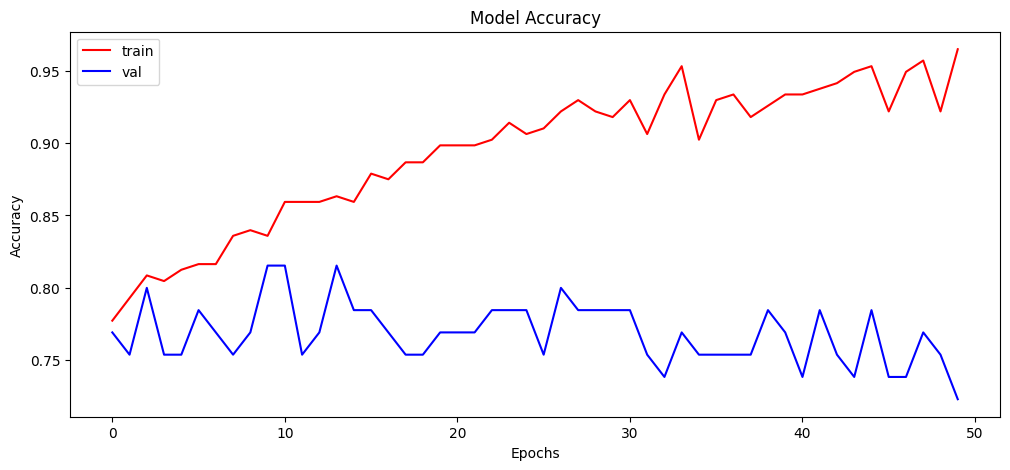

In [34]:
# Plot the training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

In [35]:
Y_pred = model.predict(X_test)
score = model.evaluate(X_test, Y_test)
print('Accuracy over the test set: \n ', round((score[1]*100), 2), '%')

2/2 [==============================] - 2s 141ms/step - loss: 3.4739 - accuracy: 0.6944
Accuracy over the test set: 
  69.44 %


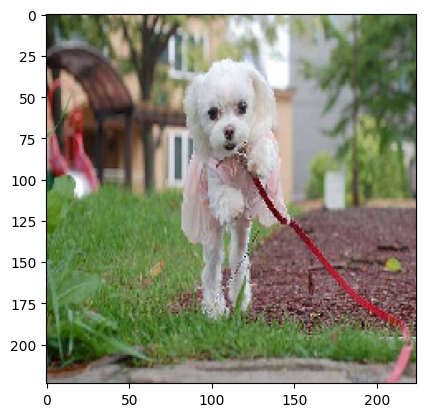

Originally :  maltese_dog
Predicted :  maltese_dog


In [36]:
# Plotting image to compare
plt.imshow(X_test[1,:,:,:])
plt.show()

# Finding max value from predition list and comaparing original value vs predicted
print("Originally : ",labels['breed'][np.argmax(Y_test[1])])
print("Predicted : ",labels['breed'][np.argmax(Y_pred[1])])